In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.08510386],
       [ 0.04120994],
       [ 0.05092595],
       [-0.05584561],
       [ 0.03814746],
       [ 0.04208072],
       [ 0.03451975],
       [-0.04137295],
       [-0.10277329],
       [ 0.05894709],
       [ 0.00978797],
       [-0.00440579],
       [-0.02984738],
       [ 0.08666822],
       [ 0.02145451],
       [-0.00940359],
       [ 0.05288672],
       [ 0.13157888],
       [ 0.29275265],
       [ 0.4556106 ]], dtype=float32), array([0.01448174], dtype=float32)]


In [7]:
print(series[1:21])
model.predict(series[1:21][np.newaxis])
# 49.35275  53.314735 57.711823 48.934444... are weights (w)
# 49.242855 is bias (b)
# Y = w0*x0+w1*x1+w2*x2+...+wn*xn + b

[49.35275  53.314735 57.711823 48.934444 48.931244 57.982895 53.897125
 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178 40.919415
 46.612473 44.228207 50.720642 44.454983 41.76799  55.980938]


array([[49.242855]], dtype=float32)

[array([[64.095695]], dtype=float32), array([[66.793274]], dtype=float32), array([[68.597]], dtype=float32), array([[67.424774]], dtype=float32), array([[63.328056]], dtype=float32), array([[65.04131]], dtype=float32), array([[65.27939]], dtype=float32), array([[67.07164]], dtype=float32), array([[66.74176]], dtype=float32), array([[65.804596]], dtype=float32), array([[64.49739]], dtype=float32), array([[68.833885]], dtype=float32), array([[65.7917]], dtype=float32), array([[68.66]], dtype=float32), array([[66.50881]], dtype=float32), array([[70.293274]], dtype=float32), array([[66.09079]], dtype=float32), array([[63.53088]], dtype=float32), array([[62.68354]], dtype=float32), array([[62.85823]], dtype=float32), array([[62.848003]], dtype=float32), array([[66.32132]], dtype=float32), array([[63.353977]], dtype=float32), array([[63.834595]], dtype=float32), array([[67.31591]], dtype=float32), array([[71.39094]], dtype=float32), array([[69.34368]], dtype=float32), array([[65.67757]], dty

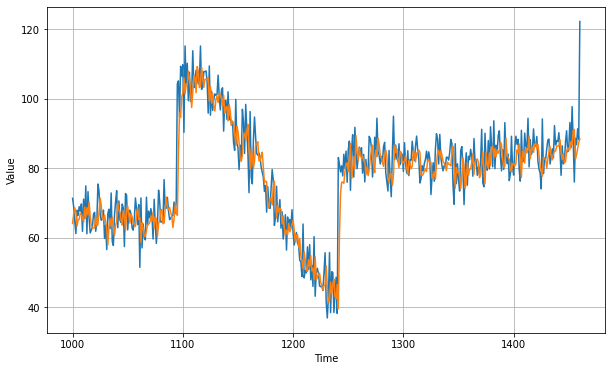

In [9]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:] # split our time series into training and testing sense (split_time-window_size = 1000 - 20 is test dataset) 
results = np.array(forecast)[:, 0, 0] #load them into a NuimPy array for charting

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0586114

In [10]:
print(forecast)

[array([[64.095695]], dtype=float32), array([[66.793274]], dtype=float32), array([[68.597]], dtype=float32), array([[67.424774]], dtype=float32), array([[63.328056]], dtype=float32), array([[65.04131]], dtype=float32), array([[65.27939]], dtype=float32), array([[67.07164]], dtype=float32), array([[66.74176]], dtype=float32), array([[65.804596]], dtype=float32), array([[64.49739]], dtype=float32), array([[68.833885]], dtype=float32), array([[65.7917]], dtype=float32), array([[68.66]], dtype=float32), array([[66.50881]], dtype=float32), array([[70.293274]], dtype=float32), array([[66.09079]], dtype=float32), array([[63.53088]], dtype=float32), array([[62.68354]], dtype=float32), array([[62.85823]], dtype=float32), array([[62.848003]], dtype=float32), array([[66.32132]], dtype=float32), array([[63.353977]], dtype=float32), array([[63.834595]], dtype=float32), array([[67.31591]], dtype=float32), array([[71.39094]], dtype=float32), array([[69.34368]], dtype=float32), array([[65.67757]], dty

In [11]:
print(results)

[ 64.095695  66.793274  68.597     67.424774  63.328056  65.04131
  65.27939   67.07164   66.74176   65.804596  64.49739   68.833885
  65.7917    68.66      66.50881   70.293274  66.09079   63.53088
  62.68354   62.85823   62.848003  66.32132   63.353977  63.834595
  67.31591   71.39094   69.34368   65.67757   65.0824    66.534065
  64.72489   62.404453  57.872623  63.152603  65.44953   63.283478
  65.88916   63.224293  60.604862  63.477386  64.69366   70.02678
  67.97931   67.20619   65.021545  63.60576   67.76462   66.223854
  61.987186  68.012184  69.058876  66.470726  64.17624   66.72544
  66.06407   64.18552   63.788246  63.207855  67.02097   68.54483
  65.22168   65.68073   58.608982  64.31717   62.62139   60.287598
  60.48154   61.98166   63.78988   63.90536   64.33681   65.93815
  64.821106  67.32937   62.75589   66.033394  65.35116   60.37157
  63.99234   65.00841   67.83059   68.14993   64.02066   64.15792
  68.42241   71.70865   68.754486  68.03093   68.73166   67.211464
  6